# nPRFs & GMs ?
loops over gradient_n and performs correlation with nPRF-R2 map while controlling for spatial autocorrelation (spin-permutation test) 
--> randomizes (rotates) over gradient map, nPRF stays

1. MagJudge task gradients with nPRFs (fsaverage5)
2. Margulies resting state gradients with nPRFs (fsLR)


### Add: Data prep
* surface transformations (fsav to fsav5)
* fsavTofsLR (nPRF param)
*  transform  MarguliesFCgradients from fsLR to fsaverage5

In [2]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd
import seaborn as sns

bids_folder = '/mnt_03/ds-dnumrisk' 
key = 'encoding_model.denoise'
plot_folder = op.join(bids_folder,'plots_and_ims')
from os import listdir
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]

group = 'all'
par = 'r2'


## 1.  MagJudge task gradients, fsaverage space

In [ ]:
space = 'fsaverage5'
nPRF_dir = op.join(bids_folder,'derivatives',key,'averages')
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')
nprf_r2_L = nib.load(nPRF_fn).agg_data()
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')
nprf_r2_R = nib.load(nPRF_fn).agg_data()

nprf_r2 = np.concatenate((nprf_r2_L, nprf_r2_R))
#np.shape(nprf_r2_R)

In [12]:
from  nilearn.datasets import fetch_surf_fsaverage

fsaverage = fetch_surf_fsaverage(space) 

surf_lh, surf_rh = fsaverage.pial_left , fsaverage.pial_right # load_conte69() = surf : tuple of BSPolyData or BSPolyData
sphere_lh, sphere_rh = fsaverage.sphere_left , fsaverage.sphere_right

#pati = '/mnt_03/ds-dnumrisk/derivatives/freesurfer/fsaverage5/surf/' ; import nilearn.plotting as nplt


In [13]:
from brainspace.mesh.mesh_io import read_surface

surf_lh = read_surface(surf_lh)
surf_rh = read_surface(surf_rh)

sphere_lh = read_surface(sphere_lh)
sphere_rh = read_surface(sphere_rh)


In [14]:
from brainspace.null_models import SpinPermutations

n_rand = 1000
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

#nPRF_rotated = np.hstack(sp.randomize(nprf_r2_L, nprf_r2_R))


SpinPermutations(n_rep=1000, random_state=0)

In [ ]:
# this makes the kernel crash!
#from brainspace.plotting import plot_hemispheres

plot_hemispheres(surf_lh, surf_rh, array_name=nPRF_rotated[:3], size=(1200, 600),
                 cmap='viridis', nan_color=(0.5, 0.5, 0.5, 1), color_bar=True,
                 zoom=1.55, label_text=['Rot0', 'Rot1', 'Rot2'])

In [ ]:
# 
sub='All'
n_comp = 10
grad_folder = 'derivatives/gradients'
fn = op.join(bids_folder,grad_folder,f'sub-{sub}',f'sub-{sub}_gradients_N-{n_comp}.npy')
grad = np.load(fn)

feats = {}
rotated = {}
for n_grad in range(5,10):
    gm = np.split(grad[n_grad],2) 
    gradients = np.concatenate((gm[0], gm[1]))
    gm_rotated = np.hstack(sp.randomize(gm[0], gm[1]))

    feats[f'grad{n_grad+1}'] = gradients
    rotated[f'grad{n_grad+1}'] = gm_rotated


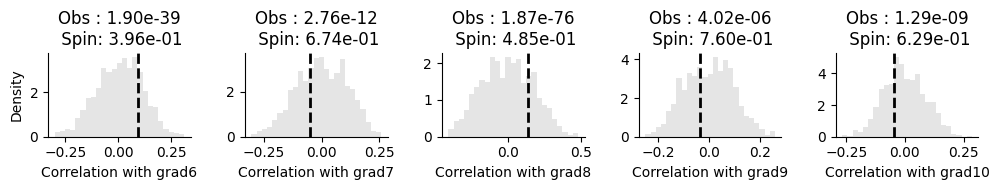

In [ ]:
import seaborn as sns
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, len(feats), figsize=(len(feats)*2, 2))

r_spin = np.empty(n_rand)
mask = ~np.isnan(gradients)

for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = spearmanr(feat[mask], nprf_r2[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = spearmanr(perm[mask_rot], nprf_r2[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    axs[k].set_title(f'Obs : {pv_obs:.2e}\n Spin: {pv_spin:.2e}')
    if k == 0:
        axs[k].set_ylabel('Density')
    #print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5e}\n Spin: {pv_spin:.5e}\n')

fig.tight_layout()
sns.despine()
plt.show()



## 2. Margulies16 resting state Gradients

In [20]:
# load nPRF-r2 in fsLR space
space = 'fsLR_den-32k'

nPRF_L = nib.load(op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')).agg_data()
nPRF_R = nib.load(op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')).agg_data()

nPRF = np.concatenate((nPRF_L, nPRF_R))

In [21]:
from neuromaps.datasets import fetch_atlas

fsLR = fetch_atlas('fsLR', '32k')
fsLR['sphere'][0]

from brainspace.mesh.mesh_io import read_surface

surf_lh = read_surface(str(fsLR['midthickness'][0]))
surf_rh = read_surface(str(fsLR['midthickness'][1]))

sphere_lh = read_surface(str(fsLR['sphere'][0]))
sphere_rh = read_surface(str(fsLR['sphere'][1]))

In [22]:
from brainspace.null_models import SpinPermutations

n_rand = 1000
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

SpinPermutations(n_rep=1000, random_state=0)

In [ ]:
from neuromaps.datasets import fetch_annotation

margulies2016 = fetch_annotation(source='margulies2016')

feats = {}
rotated = {}
for n_grad in range(5):
    margulies_grad_L= nib.load(margulies2016['margulies2016',f'fcgradient0{n_grad+1}','fsLR','32k'][0]).agg_data()
    margulies_grad_R= nib.load(margulies2016['margulies2016',f'fcgradient0{n_grad+1}','fsLR','32k'][1]).agg_data()

    gradients = np.concatenate((margulies_grad_L,margulies_grad_R))
    gm_rotated = np.hstack(sp.randomize(margulies_grad_L, margulies_grad_R))

    feats[f'grad{n_grad+1}'] = gradients
    rotated[f'grad{n_grad+1}'] = gm_rotated

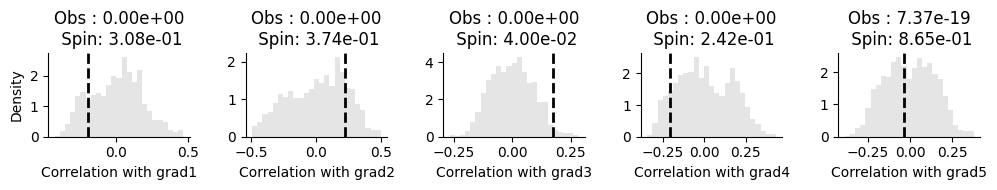

In [25]:
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

fig, axs = plt.subplots(1, len(feats), figsize=(len(feats)*2, 2))

mask = ~np.isnan(gradients)
r_spin = np.empty(n_rand)

for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = spearmanr(feat[mask], nPRF[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = spearmanr(perm[mask_rot], nPRF[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    axs[k].set_title(f'Obs : {pv_obs:.2e}\n Spin: {pv_spin:.2e}')
    if k == 0:
        axs[k].set_ylabel('Density')
    #print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5e}\n Spin: {pv_spin:.5e}\n')

fig.tight_layout()
sns.despine()
plt.show()

## GMs-CoordinateSystem - r2-nPRF-cmap

In [8]:
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
space = 'fsaverage5'
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')
nprf_r2_L = nib.load(nPRF_fn).agg_data()
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')
nprf_r2_R = nib.load(nPRF_fn).agg_data()

nprf_r2 = np.concatenate((nprf_r2_L, nprf_r2_R))
np.shape(nprf_r2)

(20484,)

In [3]:
sub='All'
n_comp = 10
grad_folder = 'derivatives/gradients'
fn = op.join(bids_folder,grad_folder,f'sub-{sub}',f'sub-{sub}_gradients_N-{n_comp}.npy')
grad = np.load(fn)

np.shape(grad)

(10, 20484)

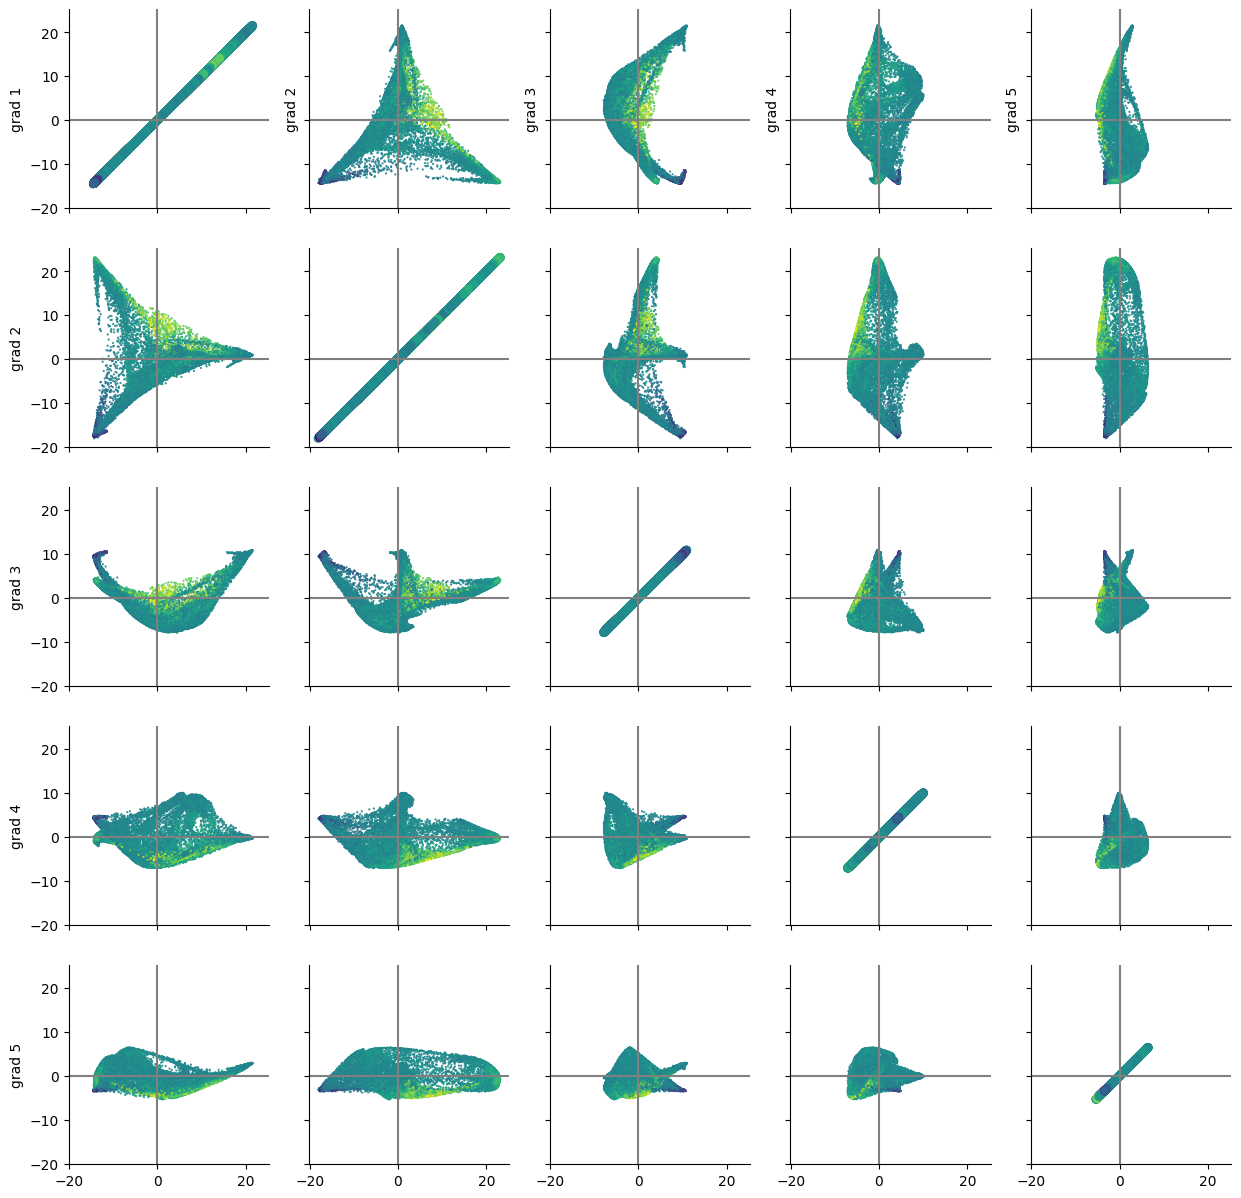

In [ ]:

n_comp = int(5)
fig, axes = plt.subplots(n_comp, n_comp, figsize=(15,15), sharex=True , sharey= True) #, facecolor='white', constrained_layout=True)

for i in range(n_comp):
    for j in range(n_comp):
        marker_size = 30 if i == j else 0.3
        axes[i,j].scatter(grad[j,:],grad[i,:],  c=nprf_r2, s=marker_size)
        sns.despine(ax=axes[i,j])
        axes[i,j].axvline(0,c='grey')
        axes[i,j].axhline(0,c='grey')
        
        axes[i, j].set_ylabel(f'grad {i+1}') if j == 0 else None
        axes[i, j].set_xlabel(f'grad {j+1}') if i == 4 else None



### GMs-Coordinates & r2-nPRFs-Cmap for individual subjects
into one pdf fig

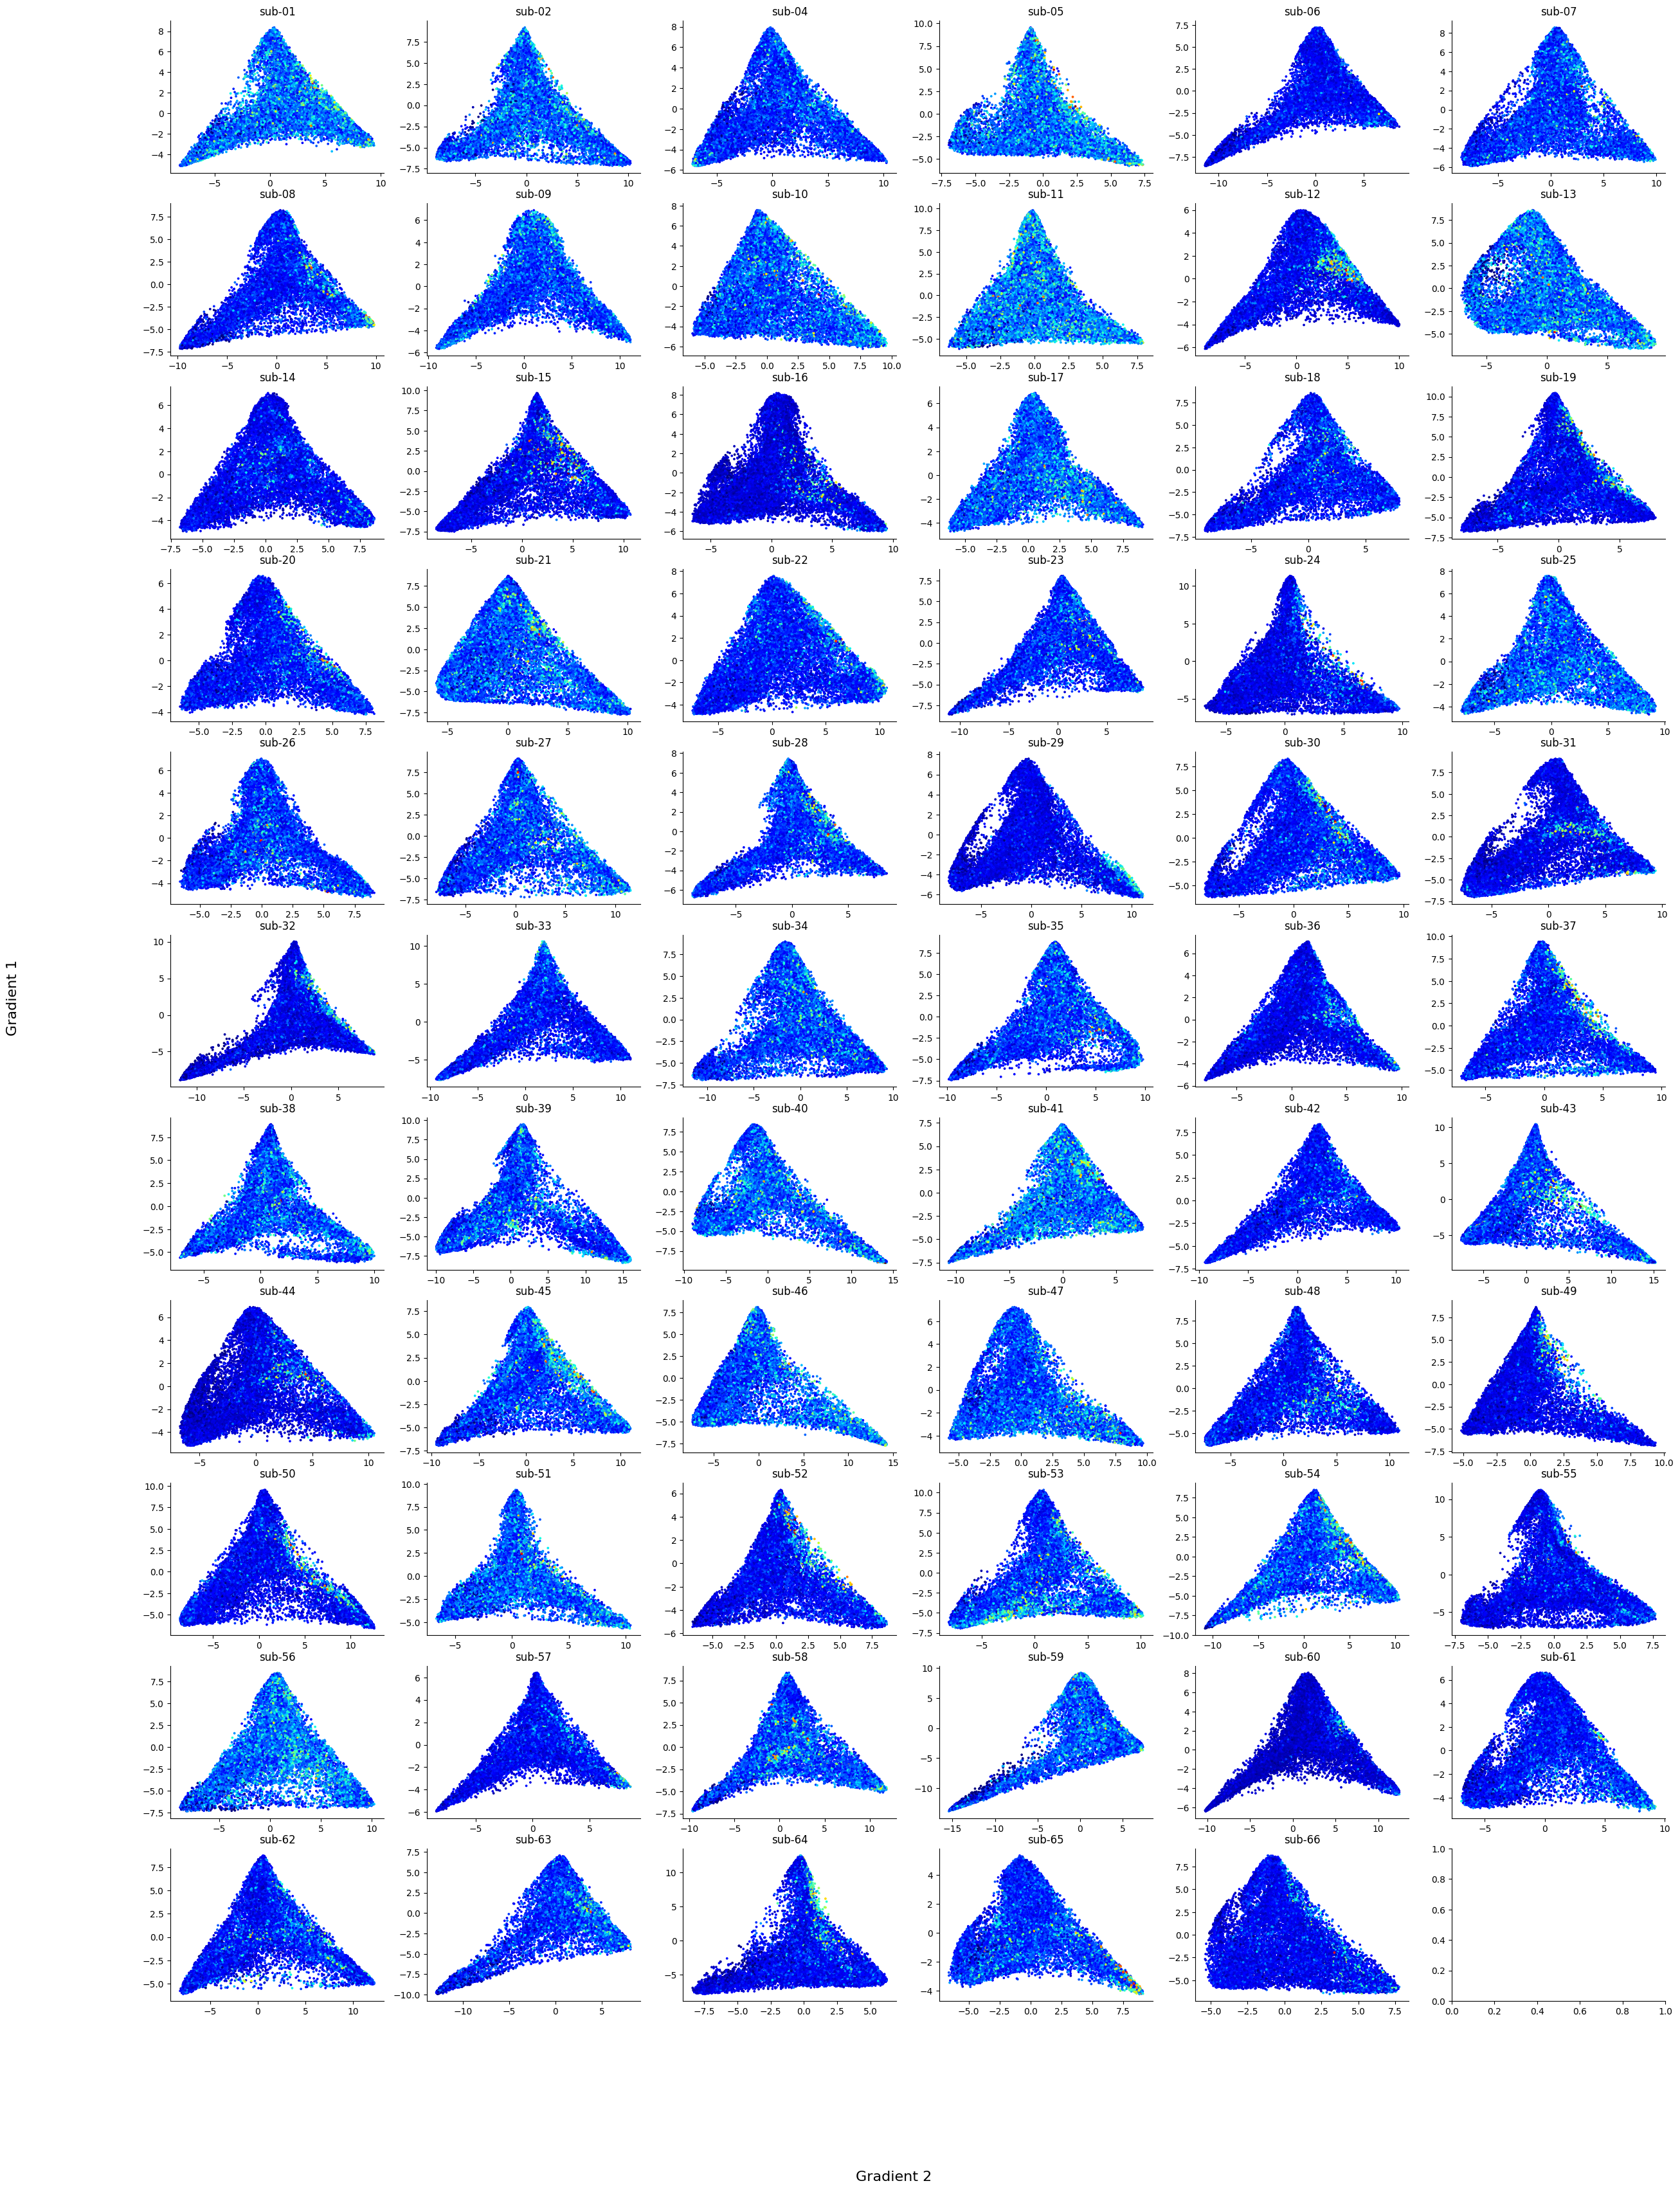

In [3]:
space = 'fsaverage5'
spec = 'g-aligned' # gradients

fig, axs = plt.subplots(nrows=11,ncols=6,figsize=(30,40))
axs = axs.flatten()

subList = sorted(subList, key=lambda x: int(x))
subList.remove('03')
for idx, sub in enumerate(subList):
    nPRF_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1','func')
    nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')
    nprf_r2_L = nib.load(nPRF_fn).agg_data()
    nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')
    nprf_r2_R = nib.load(nPRF_fn).agg_data()
    nprf_r2 = np.concatenate((nprf_r2_L, nprf_r2_R))

    n_comp = 10
    fn = op.join(bids_folder,'derivatives/gradients',f'sub-{sub}',f'sub-{sub}_{spec}_space-fsaverag5_n10.npy') #space-{space}_n{n_comp}.npy')
    grad = np.load(fn)
    ax = axs[idx]
    ax.scatter(grad[1,:],grad[0,:], c=nprf_r2, s=3,cmap='jet') # x,y -- ylabel = grad2 ; xlabel = grad1
    ax.set(title=f'sub-{sub}') # xlabel='grad 2', ylabel='grad 1',
    sns.despine()

# Add collective x and y labels
fig.text(0.5, 0.04, 'Gradient 2', ha='center', fontsize=16)  # x-label
fig.text(0.04, 0.5, 'Gradient 1', va='center', rotation='vertical', fontsize=16)  # y-label

plt.savefig(op.join(plot_folder, 'GMs-coordinate_nPRF-cmap_indSubs.pdf'),bbox_inches='tight', dpi=300)

In [71]:
from utils import get_nPRFs_params

sub = '43'
nprf_r2 = get_nPRFs_params(sub=sub,bids_folder=bids_folder)



In [72]:
n_grad = 1
dir = op.join(bids_folder,'derivatives/gradients',f'sub-Margulies16')
fn =  op.join(dir, f'sub-Margulies16_grad-{n_grad}_space-fsaverage5_hemi-L.func.gii')
gM_L = nib.load(fn).agg_data()
fn =  op.join(dir, f'sub-Margulies16_grad-{n_grad}_space-fsaverage5_hemi-R.func.gii')
gM_R = nib.load(fn).agg_data()
grad1_Marg= np.concatenate((gM_L, gM_R))

n_grad = 2
dir = op.join(bids_folder,'derivatives/gradients',f'sub-Margulies16')
fn =  op.join(dir, f'sub-Margulies16_grad-{n_grad}_space-fsaverage5_hemi-L.func.gii')
gM_L = nib.load(fn).agg_data()
fn =  op.join(dir, f'sub-Margulies16_grad-{n_grad}_space-fsaverage5_hemi-R.func.gii')
gM_R = nib.load(fn).agg_data()
grad2_Marg= np.concatenate((gM_L, gM_R))

spec = 'g-aligned'
fn = op.join(bids_folder,'derivatives/gradients',f'sub-{sub}',f'sub-{sub}_{spec}_space-fsaverag5_n10.npy') #space-{space}_n{n_comp}.npy')
grad_sub = np.load(fn) # grad[1,:],grad[0,:]

Text(0.5, 1.05, 'sub-43')

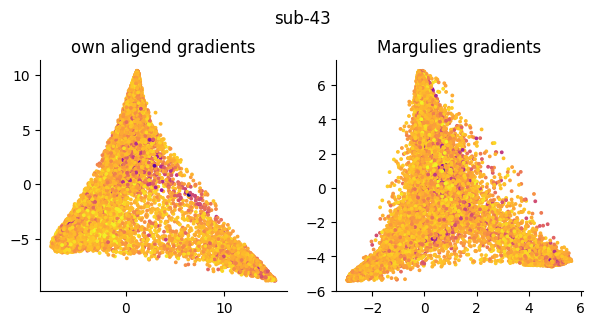

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(7,3))
cmap = 'plasma_r'
ax[0].scatter(grad_sub[1,:],grad_sub[0,:], c=nprf_r2, s=3,cmap=cmap) # x,y -- ylabel = grad2 ; xlabel = grad1
ax[1].scatter(grad2_Marg,grad1_Marg, c=nprf_r2, s=3,cmap=cmap) # x,y -- ylabel = grad2 ; xlabel = grad1
ax[0].set(title='own aligned gradients')
ax[1].set(title='Margulies gradients')
sns.despine()

fig.suptitle(f'sub-{sub}',y=1.05)

# addtional stuff

In [ ]:
from nipype.interfaces.freesurfer import SurfaceTransform # needs the fsaverage & fsaverage5 in ..derivatives/freesurfer folder!
source_space = 'fsaverage'
target_space = 'fsaverage5'

for hemi in ['L', 'R']:
    sxfm = SurfaceTransform(subjects_dir=op.join(bids_folder,'derivatives','freesurfer'))
    sxfm.inputs.source_file = op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{source_space}_hemi-{hemi}.func.gii')
    sxfm.inputs.out_file = op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{target_space}_hemi-{hemi}.func.gii')
    sxfm.inputs.source_subject = source_space 
    sxfm.inputs.target_subject = target_space 
    sxfm.inputs.hemi = 'lh' if hemi == 'L' else 'rh'

    r = sxfm.run()

In [ ]:
from numrisk.fmri_analysis.surface.vol2surf_nPRFsParams import transform_fsaverage

par = 'r2'

for sub in subList:
    nPRF_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1','func')
    nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-fsaverage5_hemi-L.func.gii') 
    if (os.path.exists(nPRF_fn) == False):
        for hemi in ['L', 'R']:
            fs_hemi = 'lh' if hemi == 'L' else 'rh'
            nPRF_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1','func')
            nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-fsnative_hemi-{hemi}.func.gii') 
            transform_fsaverage(in_file = nPRF_fn, fs_hemi= fs_hemi, source_subject = f'sub-{sub}', bids_folder=bids_folder, target_space = 'fsaverage5')

In [ ]:
from numrisk.fmri_analysis.surface.vol2surf_nPRFsParams import transform_fsaverage

sub='02'
par = 'r2'
for hemi in ['L', 'R']:
    fs_hemi = 'lh' if hemi == 'L' else 'rh'
    nPRF_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1','func')
    nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-fsnative_hemi-{hemi}.func.gii') 
    transform_fsaverage(in_file = nPRF_fn, fs_hemi= fs_hemi, source_subject = f'sub-{sub}', bids_folder=bids_folder, target_space = 'fsaverage5')

In [7]:
margulies_grad_L

array([ 6.379188 , -4.9558477, -2.9024293, ...,  6.10565  ,  6.2044196,
        6.0255275], dtype=float32)

In [23]:
# transform  MarguliesFCgradients from fsLR to fsaverage5

from neuromaps.transforms import fslr_to_fsaverage
from neuromaps.datasets import fetch_annotation
target_space = 'fsaverage5'
margulies2016 = fetch_annotation(source='margulies2016')
target_dir = op.join(bids_folder,'derivatives/gradients', 'sub-Margulies16')

n_grad = 5
for i, hemi in enumerate(['L','R']):
    margulies_grad = nib.load(margulies2016['margulies2016',f'fcgradient0{n_grad}','fsLR','32k'][i])#.agg_data()
    margulies_grad_fsav5 = fslr_to_fsaverage(data = margulies_grad, target_density ='10k', hemi=hemi)
    target_fn =  op.join(target_dir, f'sub-Margulies16_grad-{n_grad}_space-{target_space}_hemi-{hemi}.func.gii')
    nib.save(margulies_grad_fsav5[0], target_fn)


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    

  For {'source': 'margulies2016', 'desc': 'fcgradient02', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [se

In [11]:
target_fn

'/mnt_03/ds-dnumrisk/derivatives/gradients/sub-Margulies16/sub-Margulies16_grad-1_space-fsaverage_hemi-L.func.gii'

In [21]:
#im = nib.gifti.GiftiImage(darrays=[nib.gifti.GiftiDataArray(av_r2_map)])
hemi = 'L'
target_dir = op.join(bids_folder,'derivatives/gradients', 'sub-Margulies16')
target_fn =  op.join(target_dir, f'sub-Margulies16_grad-{n_grad}_space-{target_space}_hemi-{hemi}.func.gii')
nib.save(margulies_grad_L_fsav5[0], target_fn)